See [2-select-GD1-stars.ipynb](2-select-GD1-stars.ipynb) to see details about the selection.

In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData
import gala.coordinates as gc
import scipy.stats

In [66]:
# plt.style.use('gd1_paper')
plt.rcParams['font.size'] = 18.0

Load data:

In [3]:
g = GaiaData('../data/gd1-with-masks.fits')

In [5]:
pm_mask = g.pm_mask
cmd_mask = g.gi_cmd_mask

In [6]:
(pm_mask & cmd_mask).sum()

5133

Load isochrone and proper motion selection polygons:

In [14]:
iso = np.load('../output/iso_shifted.npy')
cmd_poly = np.load('../output/iso_poly.npy')
pm_poly = np.load('../output/pm_poly.npy')

In [86]:
phi_mask_stream = ((np.abs(g.phi2--0.5*u.deg) < 0.75*u.deg) & (g.phi1>-60*u.deg) & (g.phi1<0*u.deg))

In [87]:
polystyle = dict(color='tab:orange', alpha=0.3, linewidth=0)
ptstyle = dict(color='k', marker='o', linewidth=0, 
               markersize=2, alpha=0.15, rasterized=True)

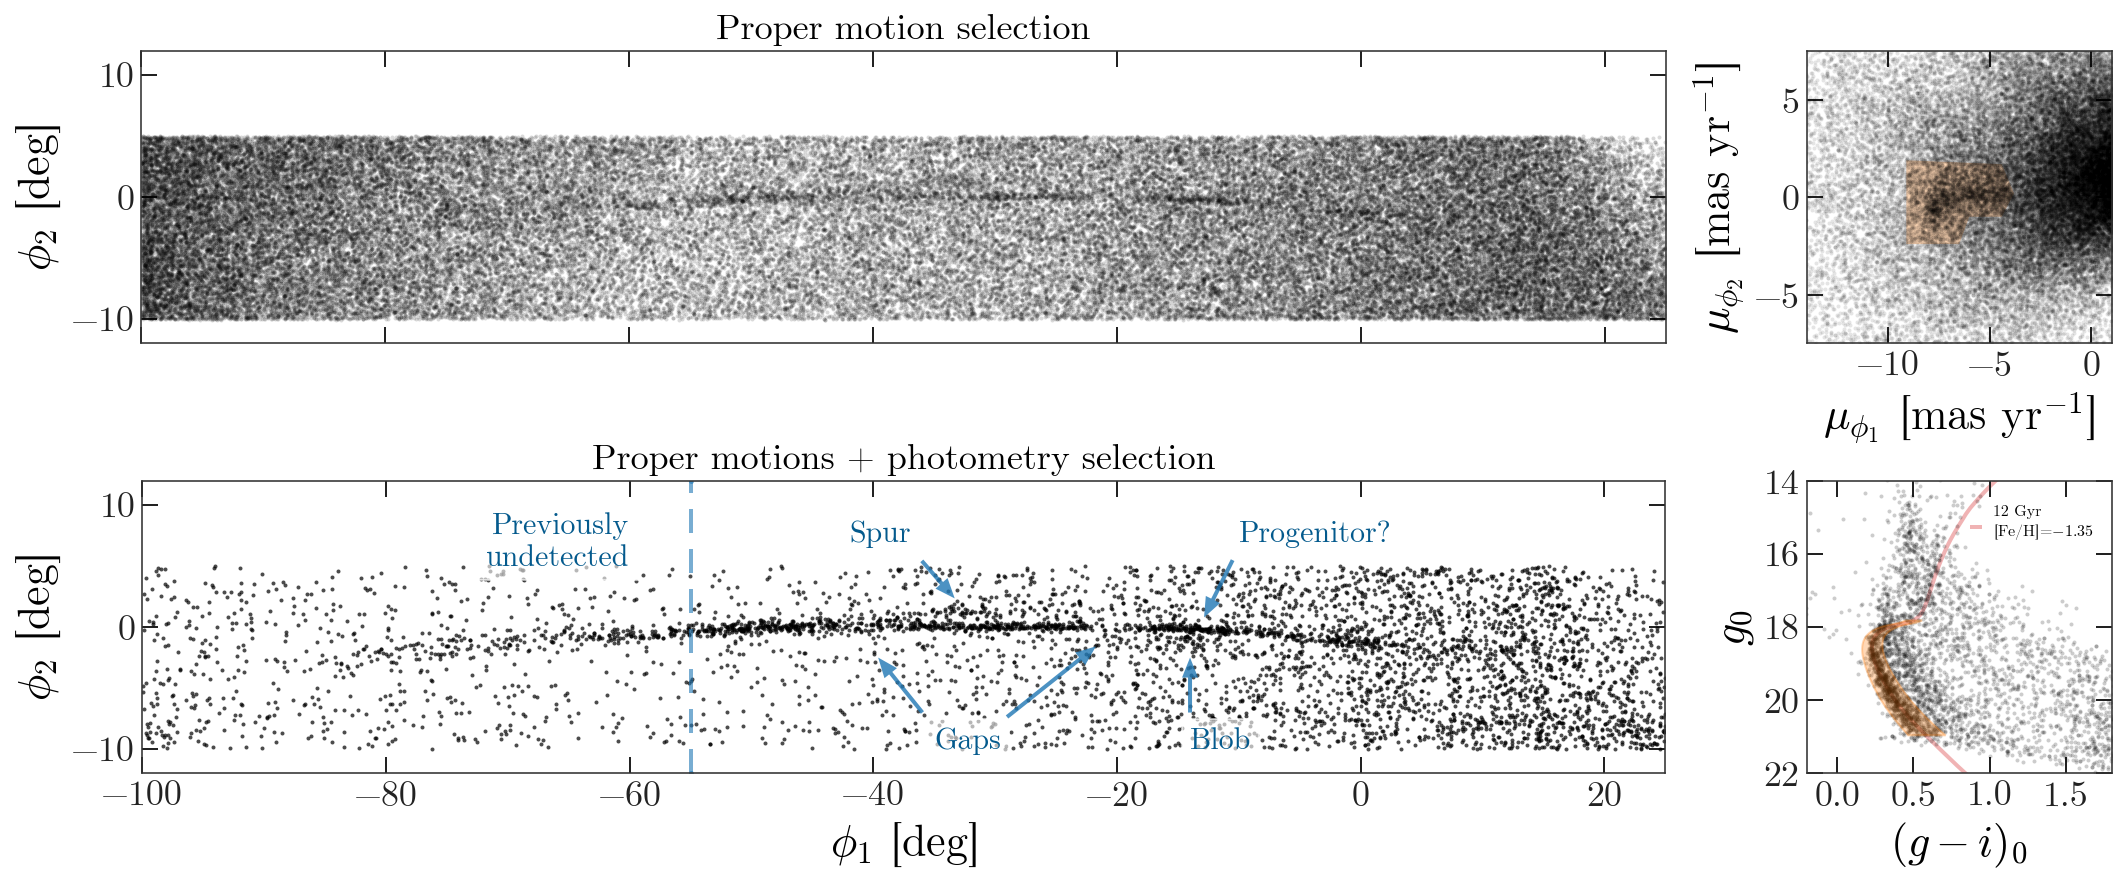

In [89]:
fig, axes = plt.subplots(2, 2,
                         figsize=(15.2, 6.5),
                         gridspec_kw={'width_ratios':[5,1]})

# sky positions filtered by proper motion selection:
ax = axes[0, 0]
ax.plot(g.phi1[pm_mask], g.phi2[pm_mask], **ptstyle)
ax.set_ylabel('$\phi_2$ [deg]')
ax.set_title('Proper motion selection', fontsize='medium')

plt.setp(ax.get_xticklabels(), visible=False)
ax.set_xlim(-100, 25)
ax.set_ylim(-12, 12)

# proper motion components
ax = axes[0, 1]
style = ptstyle.copy()
style['alpha'] = 0.1
ax.plot(g.pm_phi1_cosphi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
        g.pm_phi2_no_reflex[phi_mask_stream].to(u.mas/u.yr), 
        **style)

pr = mpl.patches.Polygon(pm_poly, **polystyle)
ax.add_artist(pr)

ax.xaxis.set_ticks([-10, -5, 0])
ax.set_xlim(-14, 1)
ax.set_ylim(-7.5, 7.5)
# ax.set_xlim(-15, 5)
# ax.set_ylim(-10, 10)
ax.set_xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
ax.set_ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')

# sky positions filtered by proper motion and CMD selection
ax = axes[1, 0]
style = ptstyle.copy()
style['alpha'] = 0.7
ax.plot(g.phi1[pm_mask & cmd_mask], g.phi2[pm_mask & cmd_mask],
        **style)
ax.set_aspect('equal')

arrow_style = dict(color='tab:blue', width=2, alpha=0.8,
                   headwidth=8, headlength=10, linewidth=0)
annot_style = dict(fontsize='small', backgroundcolor=(1,1,1,0.6), 
                   color='#045a8d')
ax.annotate('Progenitor?', xy=(-13, 0.5), xytext=(-10, 7),
            arrowprops=dict(shrink=0.05, **arrow_style),
            **annot_style)

ax.annotate('Blob', xy=(-14, -2), xytext=(-14, -10),
            arrowprops=dict(shrink=0.08, **arrow_style),
            **annot_style)

ax.annotate('Spur', xy=(-33, 2), xytext=(-42, 7),
            arrowprops=dict(shrink=0.08, **arrow_style),
            **annot_style)

ax.annotate('Gaps', xy=(-40, -2), xytext=(-35, -10),
            arrowprops=dict(shrink=0.08, **arrow_style),
            **annot_style)

style = annot_style.copy()
style.pop('backgroundcolor')
ax.annotate('      ', xy=(-21, -1), xytext=(-35, -10),
            arrowprops=dict(shrink=0.08, **arrow_style),
            **style)

ax.axvline(-55, ls='--', color='tab:blue', alpha=0.6, dashes=(6,4), lw=2)
ax.text(-60, 9.5, 'Previously\nundetected', ha='right', va='top', **annot_style)

ax.set_xlabel('$\phi_1$ [deg]')
ax.set_ylabel('$\phi_2$ [deg]')
ax.set_title('Proper motions + photometry selection', fontsize='medium')

ax.set_xlim(-100, 25)
ax.set_ylim(-12, 12)

# color-magnitude
ax = axes[1, 1]
ax.plot(g.g0[phi_mask_stream & pm_mask] - g.i0[phi_mask_stream & pm_mask], g.g0[phi_mask_stream & pm_mask], 
        'ko', ms=2, alpha=0.2, rasterized=True, label='')

ax.plot(iso[:, 0], iso[:, 1], ls='-', marker='', color='tab:red', 
        lw=2, alpha=0.35, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(cmd_poly, color='tab:orange', 
                         alpha=0.3, zorder=2, label='')
ax.add_artist(pm)

ax.legend(loc='upper right', frameon=False, fontsize=8,
          handlelength=0.5, bbox_to_anchor=(0.99,0.95))
ax.xaxis.set_ticks([0, 0.5, 1, 1.5])
ax.set_xlim(-0.2, 1.8)
ax.set_ylim(22, 14)
ax.set_xlabel('$(g - i)_0$')
ax.set_ylabel('$g_0$')

for ax in axes.flat:
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

plt.tight_layout(h_pad=0.5, w_pad=0.5)
fig.set_facecolor('w')
# plt.savefig('../paper/gd1_sample.pdf')